In [9]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle

ImportError: Unable to import required dependencies:
numpy: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.10 from "/usr/local/bin/python3"
  * The NumPy version is: "1.22.3"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython-310-darwin.so, 0x0002): tried: '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython-310-darwin.so' (no such file), '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64'))


In [3]:
df = pd.read_csv('platform_dataset.csv')

df


NameError: name 'pd' is not defined

In [80]:
df.describe()

,Cost of Purchase,Qty of Purchase,Customer ID,Seller ID,Rating,Time Taken for Transaction (s),Month of Transaction,return
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,498.662359,5.527700,54638.404600,543.747400,3.014100,59.472283,6.111400,0.402500
std,289.967500,2.864132,25933.078744,258.865612,1.411985,34.682244,3.573915,0.490426
min,0.350000,1.000000,10008.000000,100.000000,1.000000,0.010000,1.000000,0.000000
25%,246.777500,3.000000,32014.750000,318.000000,2.000000,28.840000,3.000000,0.000000
50%,496.470000,6.000000,54659.000000,540.500000,3.000000,59.640000,6.000000,0.000000
75%,751.825000,8.000000,76725.000000,765.000000,4.000000,89.110000,9.000000,1.000000
max,999.940000,10.000000,99998.000000,999.000000,5.000000,119.990000,12.000000,1.000000


In [81]:
df.columns

Index(['Type of Product', 'Date of Purchase', 'Cost of Purchase',
       'Qty of Purchase', 'Customer ID', 'Seller Brand', 'Seller ID', 'Rating',
       'Time Taken for Transaction (s)', 'Month of Transaction',
       'Time of Transaction', 'return'],
      dtype='object')

### Classification model
##### Predict whether it will be a successful transaction

In [83]:
# Separate input (X) and target (y) dataframes
# --------------------------------------------

X = df[['Date of Purchase', 'Time of Transaction', 'Qty of Purchase', 'Cost of Purchase', 'Rating']]
y = df['return']

print(X.shape,y.shape)

(10000, 5) (10000,)


In [84]:
# distribution of class
#----------------------
print(y.value_counts())

0    5975
1    4025
Name: return, dtype: int64


In [85]:
def preprocess_data(X):
    # for numerical columns
    # ---------------------
    # we normalize using MinMaxScaler to constrain values between 0 and 1

    scaler = MinMaxScaler(feature_range = (0,1))
    df_numeric = X.select_dtypes(include=[np.number])
    numeric_cols = df_numeric.columns.values

    for col in numeric_cols:
        # fit_transform() of scaler can be applied to each column individually
        X[col] = scaler.fit_transform(X[[col]])
        
    print("---Successfully processed numeric column(s)")
    print(X.head(5))
    
    # for categorical columns
    # -----------------------
    # we convert the column into one-hot encoding
    df_categorical = X.select_dtypes(exclude=[np.number])
    categorical_cols = df_categorical.columns.values
    
    # the function get_dummies() (from pandas) creates one-hot encoding
    X = pd.get_dummies(X,columns=categorical_cols)
           
    print("---Successfully processed categorical column(s)")
    print(X.head(5))
        
    return X

In [86]:
# execute preprocess_data()
#--------------------------
X = preprocess_data(X)

---Successfully processed numeric column(s)
  Date of Purchase Time of Transaction  Qty of Purchase  Cost of Purchase  \
0       11/12/2021               23:45         0.777778          0.295961   
1       10/10/2020               19:15         0.222222          0.570144   
2       07/02/2020               06:45         0.111111          0.776248   
3       11/08/2020               19:45         0.555556          0.324963   
4       11/07/2021               00:30         0.111111          0.407797   

   Rating  
0     0.5  
1     0.0  
2     0.0  
3     1.0  
4     0.5  
---Successfully processed categorical column(s)
   Qty of Purchase  Cost of Purchase  Rating  Date of Purchase_01/01/2020  \
0         0.777778          0.295961     0.5                            0   
1         0.222222          0.570144     0.0                            0   
2         0.111111          0.776248     0.0                            0   
3         0.555556          0.324963     1.0                     

<ipython-input-85-659a51132629>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = scaler.fit_transform(X[[col]])
<ipython-input-85-659a51132629>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = scaler.fit_transform(X[[col]])
<ipython-input-85-659a51132629>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 894) (2000, 894) (8000,) (2000,)


In [88]:
# create a logistic regression classifier
# ---------------------------------------
logreg = LogisticRegression(solver='liblinear', random_state=7)
logreg.fit(X_train, y_train)

# Apply the model on the test data to get a prediction
# ----------------------------------------------------
y_pred = logreg.predict(X_test)

Testing accuracy 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1195
           1       1.00      1.00      1.00       805

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



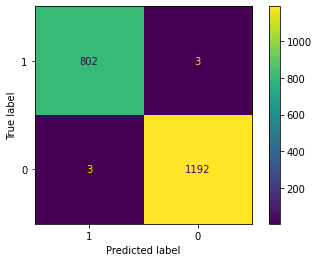

In [90]:
# Get accuracy of the model
# -------------------------
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))


# compute confusion matrix
# ------------------------
labels = [1, 0]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()

# look at the value for both 'yes' and 'no' class, the model can predict 'no' better than 'yes' 
print(classification_report(y_test, y_pred))

In [91]:
# save the model in a file to retrieve it later if necessary
# ----------------------------------------------------------
filename = 'platform_model.sav'
pickle.dump(logreg, open(filename, 'wb'))

In [92]:
# Recursive Feature Elimination (or RFE)
# --------------------------------------
# Works by recursively removing attributes and building a model 
# on those attributes that remain.
rfe = RFE(logreg, n_features_to_select=3)
fit = rfe.fit(X, y)

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False Fal

In [93]:
selected = fit.support_
# get the top-3 feature_names
feature_names = X.columns

# put your code here
# ------------------
print(feature_names.to_numpy()[selected])

['Rating' 'Date of Purchase_05/04/2020' 'Time of Transaction_12:00']


In [39]:
# In case you would like to load the model from disk
loaded_model = pickle.load(open('platform_model.sav', 'rb'))
loaded_model.predict(X_test)

array([0, 0, 1, ..., 0, 0, 0])

### Trying out of CatBoost

Why? Because it automatically deal with categorical variables and does not require extensive data preprocessing

In [61]:
df.head()

,Type of Product,Date of Purchase,Cost of Purchase,Qty of Purchase,Customer ID,Seller Brand,Seller ID,Rating,Time Taken for Transaction (s),Month of Transaction,Time of Transaction,return
0,Household Essentials,11/12/2021,296.19,8,64558,Unilever,348,3,21.88,12,23:45,0
1,Fashion,10/10/2020,570.26,3,86183,Oysho,683,1,99.90,10,19:15,0
2,Fashion,07/02/2020,776.28,2,68292,Boohoo,429,1,44.16,2,06:45,0
3,Fashion,11/08/2020,325.18,6,76947,Miss Selfridge,677,5,110.75,8,19:45,1
4,Fashion,11/07/2021,407.98,2,41309,River Island,422,3,40.59,7,00:30,0


In [1]:
from catboost import CatBoostClassifier
from sklearn import metrics

X = df[['Date of Purchase', 'Time of Transaction', 'Qty of Purchase', 'Cost of Purchase', 'Rating']]
y = df['return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5)

# Instantiate the model object
model = CatBoostClassifier(learning_rate=0.1, random_seed=5)

# Fit the model with the training data
model.fit(X_train, y_train, cat_features=([0, 1]))  # set verbose=False if you find the logs too long

# Predict the target on the test dataset
y_predict = model.predict(X_test)
print('\nPrediction on test data', y_predict) 

# Accuracy Score on test dataset
accuracy_test = metrics.accuracy_score(y_test, y_predict)
print('\nAccuracy_score on test dataset : ', accuracy_test)

# F1 Score on test dataset
f1_test = f1_score(y_test, y_predict)
print('\nF1 Score on test dataset : ', f1_test)

# save the model in a file to retrieve it later if necessary
# ----------------------------------------------------------
filename = 'platform_model_catboost.sav'
pickle.dump(model, open(filename, 'wb'))

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.10 from "/usr/local/bin/python3"
  * The NumPy version is: "1.22.3"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython-310-darwin.so, 0x0002): tried: '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython-310-darwin.so' (no such file), '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64'))


## Trying out XGBoost

In [67]:
X

,Date of Purchase,Time of Transaction,Qty of Purchase,Cost of Purchase,Rating
0,11/12/2021,23:45,8,296.19,3
1,10/10/2020,19:15,3,570.26,1
2,07/02/2020,06:45,2,776.28,1
3,11/08/2020,19:45,6,325.18,5
4,11/07/2021,00:30,2,407.98,3
...,...,...,...,...,...
9995,07/01/2020,19:00,2,664.69,5
9996,26/07/2021,21:15,8,38.83,4
9997,28/08/2021,15:45,10,168.13,1
9998,29/05/2020,23:30,7,488.81,3


In [99]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier


X = df[['Date of Purchase', 'Time of Transaction', 'Qty of Purchase', 'Cost of Purchase', 'Rating']]
y = df['return']

X = preprocess_data(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5)


# Instantiate the model object
model = xgb.XGBClassifier(learning_rate=0.1, random_state=5, eval_metric='error')

# Fit the model with the training data
model.fit(X_train, y_train)

# predict the target on the test dataset
y_predict = model.predict(X_test)
print('\nPrediction on test data', y_predict) 

# Accuracy Score on test dataset
accuracy_test = metrics.accuracy_score(y_test, y_predict)
print('\nAccuracy_score on test dataset : ', accuracy_test)


# F1 Score on test dataset
f1_test = f1_score(y_test, y_predict)
print('\nF1 Score on test dataset : ', f1_test)

# save the model in a file to retrieve it later if necessary
# ----------------------------------------------------------
filename = 'platform_model_xgboost.sav'
pickle.dump(logreg, open(filename, 'wb'))


<ipython-input-85-659a51132629>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = scaler.fit_transform(X[[col]])
<ipython-input-85-659a51132629>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = scaler.fit_transform(X[[col]])
<ipython-input-85-659a51132629>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

---Successfully processed numeric column(s)
  Date of Purchase Time of Transaction  Qty of Purchase  Cost of Purchase  \
0       11/12/2021               23:45         0.777778          0.295961   
1       10/10/2020               19:15         0.222222          0.570144   
2       07/02/2020               06:45         0.111111          0.776248   
3       11/08/2020               19:45         0.555556          0.324963   
4       11/07/2021               00:30         0.111111          0.407797   

   Rating  
0     0.5  
1     0.0  
2     0.0  
3     1.0  
4     0.5  
---Successfully processed categorical column(s)
   Qty of Purchase  Cost of Purchase  Rating  Date of Purchase_01/01/2020  \
0         0.777778          0.295961     0.5                            0   
1         0.222222          0.570144     0.0                            0   
2         0.111111          0.776248     0.0                            0   
3         0.555556          0.324963     1.0                     

1. LogisticRegression - 99.7%
2. CatBoost - 99.9%
3. XGBoost - Accuracy: 99.9%